In [87]:
import pandas as pd
import numpy as np

import nltk
from konlpy.tag import Okt; okt = Okt()
from collections import Counter

from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
import gensim

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
# import graphviz
# from sklearn.tree import export_graphviz
from matplotlib import font_manager, rc

import warnings
import time



In [17]:
data = pd.read_csv('신문기사모음(9.17)(utf8).csv')
# data.head()

In [18]:
text = data.body
# text

In [29]:
for i, document in enumerate(text):

    # okt = Okt()
    clean_words = []
    for word in okt.pos(document, stem=True): #어간 추출
        if word[1] not in ['Josa', 'Eomi', 'Punctuation', 'Foreign', 'Suffix' ,'URL', 'Conjunction']: #조사, 어미, 구두점, 외국어/기호, url 제외 
            clean_words.append(word[0])
    # print(clean_words) 
    document = ' '.join(clean_words)
    # print(document) 
    text[i] = document

print(text[0], text[1])

C:\Users\admin\anaconda3\envs\konlp\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


NHN 빅풋 한게임 20년 웹 보드 게임 노하우 접목 스포츠 예측 게임 한게임 승부 예측 출시 하다 11일 밝히다 한게임 승부 예 측은 게임 내 재화 활용 하다 스포츠 경기 결과 예측 하다 보다 게임 실제 전세계 스포츠 경기 데이터 바탕 결과 맞다 힐 경우 배당률 따르다 게임 멀다 제공 다 특히 NHN 빅풋 한게임 웹 보드 게임 개발 및 서비스 노하우 바탕 차별 되다 스포츠 예측 게임 선보이다 먼저 축구 야구 농구 등 대중 인기 스포츠 외 아이스하키 테니스 탁구 등 50 종 이상 방대하다 종목 제공 하다 선택 넓히다 국내 프로 스포츠 아니다 잉글랜드 프리미어리그 EPL 메이저리그 MLB 미국 프로농구 NBA 오다 같다 글로벌 인기 리그 모두 포함 되다 스포츠 예측 항목 승무 패 핸디캡 언 더 오버 포함 하다 120 여종 달 다 이용자 경기 당 결과 예측 다양하다 항목 선택 하다 전략 게임 즐기다 수 있다 또한 이용자 성향 맞추다 즐기다 수 있다 콘텐츠 마련 하다 크로스 하다 경기 내 여러 항목 조합 하다 수 있다 높다 수준 예측 가능하다 스페셜 전반전 혹은 1 쿼터 등 결과 제공 하다 빠르다 호흡 게임 즐기다 수 있다 라이브 실제 경기 시작 되다 후 상황 지켜보다 실시간 예측 하다 수 있다 특별하다 방식 이 승부 예측 게임 처음 접 하다 이용자 쉬 즐기다 수 있다 직관 깔끔하다 UI 를 적용 하다 북마크 활용 하다 주요 경기 추천 Hot League 관심 경기 저장 My Favorite 과 같다 기능 제공 하다 이용자 편의 높이 경 기별 전력 분석 토론 등 통해 경기 결과 예측 도움 주다 한게임 승부 예 측은 별도 설치 과정 없이 웹페이지 바로 게임 즐기다 수 있다 NHN 은 올해 3분 연결 기준 매출 4194억원 영업 이익 274억원 기록 하다 13일 밝히다 지난해 같다 기간 각각 19.2% 24.5% 늘어나다 것 3분 실적 결제 커머스 사업 이끌다 코로나 19 여파 비대 시장 확장 되다 사업 성장하다 매출 부문 별로 살펴보다 결제 광고 매출 전 년 대비 3

In [56]:
# tokenize 
okt=Okt()
noun = []
# stopwords = ['하다', '되다', '있다', '들다', '들', '기자', '오다', '돼다', '년']
stopwords = ['기자', '년']


'''각 기사별로 토큰들 나눠서 리스트로 만들기 (명사만)'''
# [ [1번 기사의 토큰들], [2번 기사의 토큰들], [3번 기사의 토큰들]... [n번 기사의 토큰들] ]
for line in text:
    noun.append(okt.nouns(line))

# noun -> 각 기사별 명사 토큰 list를 모아놓은 list   (list를 모은 list)


# 새로운 dict tokens_processed 생성 
tokens_processed = {}
whole = []


# 기사 하나하나 마다 [토큰 리스트]에 담긴 한글자짜리 토큰 제거
temp_index = 0
for lst in noun:
    ''' 여기서 각 기사 한줄 한줄씩 처리함 '''
    
    
    # 딕셔너리에 담을 때 표시하기 위한 인덱스....
    
    
    # 딕셔너리에 담을 토큰들 모아놓는 리스트....
    temp_words_list = []
    
    
    for wd in lst:
        ''' 여기서 기사별 [토큰list] 속 단어(토큰)들을 처리함 '''
        
        if len(wd) < 2:
            # 한글자 짜리면 무시하고 지나침
            continue
            
        if wd in stopwords:
            # 불용어에 해당하는 단어면 무시하고 지나침
            continue
        
        # 둘다 해당하지 않으면 임시 리스트에 담기
        temp_words_list.append(wd)
    
    
    # 필터링한 데이터 저장
    tokens_processed[temp_index] = temp_words_list
    whole.extend(temp_words_list)
    temp_index +=1

    ''' 
      0 : [ 기사1 토큰리스트 ]
      1 : [ 기사2 토큰리스트 ]
      2 : [ 기사3 토큰리스트 ]
    ...
    122 : [ 기사122 토큰리스트 ]
    
    (temp_index)    :  (temp_wors_list) 
    이런 형식으로 dictionary(tokens_processed)에 저장
    
    '''
    

# tokens_processed
# whole

In [44]:
# 출현 빈도수 높은 단어 순

tok = nltk.Text(whole)
common_words = tok.vocab().most_common(30)
common_words

[('게임', 1019),
 ('매출', 518),
 ('대비', 276),
 ('증가', 230),
 ('출시', 189),
 ('사업', 182),
 ('보드', 180),
 ('동기', 180),
 ('부문', 175),
 ('기록', 158),
 ('영업', 153),
 ('서비스', 147),
 ('이익', 147),
 ('네오위즈', 145),
 ('모바일', 139),
 ('결제', 135),
 ('실적', 133),
 ('시장', 133),
 ('규제', 131),
 ('코로나', 125),
 ('이용자', 116),
 ('대표', 115),
 ('스포츠', 112),
 ('글로벌', 112),
 ('국내', 108),
 ('성장', 100),
 ('지난해', 98),
 ('확대', 98),
 ('개발', 97),
 ('분기', 92)]

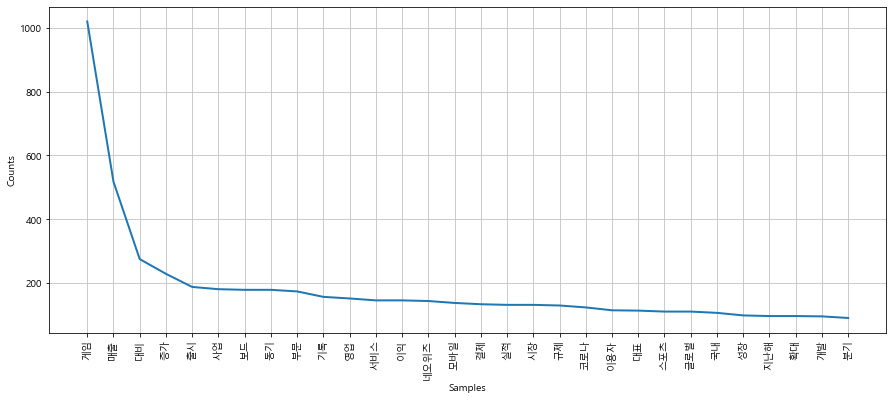

In [42]:
# 단어 출현 빈도수에 따른 그래프
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
#matplotlib.rc('font', family="NanumBarunGothic")

plt.figure(figsize=(15,6))
tok.plot(30)
plt.show()

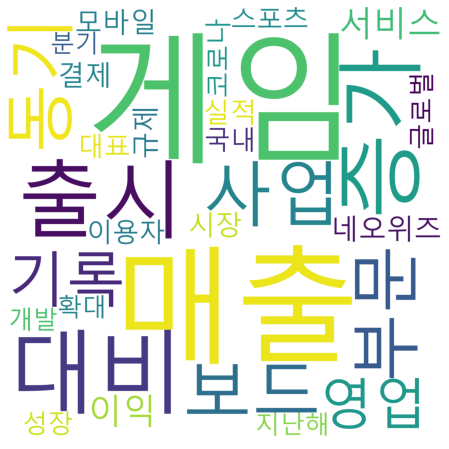

In [47]:
# 단어 출현 빈도수에 따른 워드클라우드
wordcloud = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
                     relative_scaling = 0.2,
                     background_color = 'white',
                     width = 3000, height = 3000,
                     max_words = 100).generate_from_frequencies(dict(common_words))
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [57]:
# text_processed: list -> dict 변환
tokens_dictionary = corpora.Dictionary(noun)
print(tokens_dictionary)

Dictionary(3076 unique tokens: ['개발', '게임', '결과', '경', '경기']...)


In [59]:
# 문서-단어 매트릭스 형성
tokens_corpus = [tokens_dictionary.doc2bow(text) for text in noun]
print(tokens_corpus[0])

[(0, 1), (1, 11), (2, 5), (3, 1), (4, 8), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 4), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 2), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 7), (49, 1), (50, 1), (51, 1), (52, 7), (53, 1), (54, 4), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1), (60, 1), (61, 1), (62, 2), (63, 10), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 4), (71, 2), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 4), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 2), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 2), (104, 1), (105, 1), (106, 1), (107, 5), (108, 3), (109, 1), (110, 1

In [63]:
# coherence와 perplexity 계산을 통해 최적의 pass 구하기
tokens_perplexities = []
tokens_coherences = []
passes=[]
warnings.filterwarnings('ignore')

for i in range(10):
    
    ntopics, nwords = 200, 100
    if i==0:
        p=1
    else:
        p=i*5
    tic = time.time()
    lda4 = LdaModel(tokens_corpus, id2word=tokens_dictionary, num_topics=ntopics, iterations=400, passes=p)
    print('epoch',p,time.time() - tic)
    passes.append(p)
    # lda = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=ntopics, iterations=200000)

    cm = CoherenceModel(model=lda4, corpus=tokens_corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print("Coherence",coherence)
    tokens_coherences.append(coherence)
    print('Perplexity: ', lda4.log_perplexity(tokens_corpus),'\n')
    tokens_perplexities.append(lda4.log_perplexity(tokens_corpus))

epoch 1 5.724695920944214
Coherence -0.341498295875564
Perplexity:  -9.059318072418124 

epoch 5 9.517554998397827
Coherence -0.3434338420379558
Perplexity:  -7.896190688648098 

epoch 10 13.398181915283203
Coherence -0.36202515614441194
Perplexity:  -7.4247817303549795 

epoch 15 16.484930992126465
Coherence -0.36568595260037673
Perplexity:  -7.3160921063565185 

epoch 20 22.60756278038025
Coherence -0.408210987788915
Perplexity:  -7.297493621792648 

epoch 25 22.134825706481934
Coherence -0.3289367054139168
Perplexity:  -7.245310429530779 

epoch 30 29.955918312072754
Coherence -0.3854062522141439
Perplexity:  -7.275545605898525 

epoch 35 30.390753507614136
Coherence -0.4181861105217946
Perplexity:  -7.328950197715605 

epoch 40 35.124101877212524
Coherence -0.40053272324173333
Perplexity:  -7.25057613033692 

epoch 45 41.366413593292236
Coherence -0.45509097965981704
Perplexity:  -7.2096394677519715 



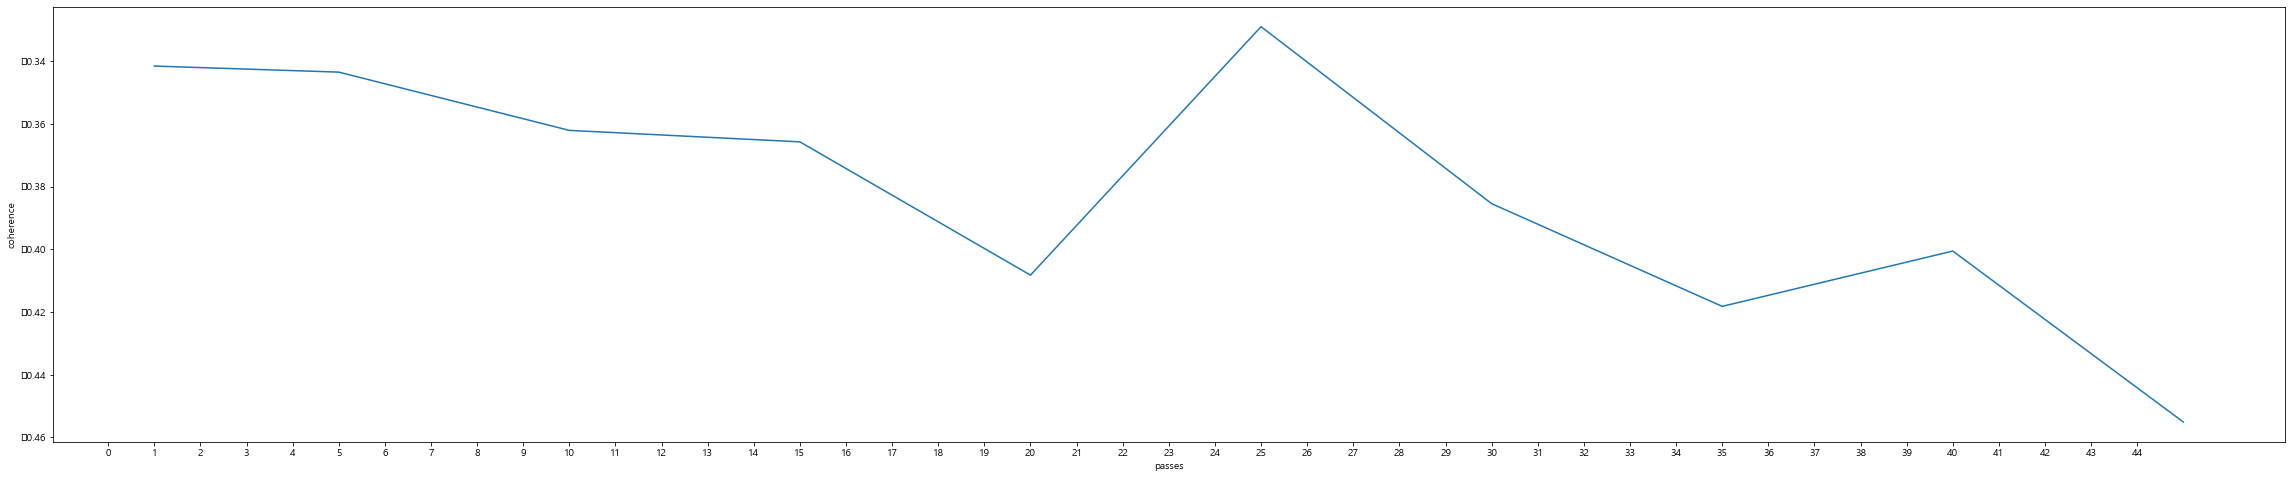

In [76]:
plt.figure(figsize=(40,8))
plt.plot(passes, tokens_coherences)

plt.xlabel("passes")
plt.ylabel("coherence")

plt.xticks(np.arange(0, 45))

plt.show()

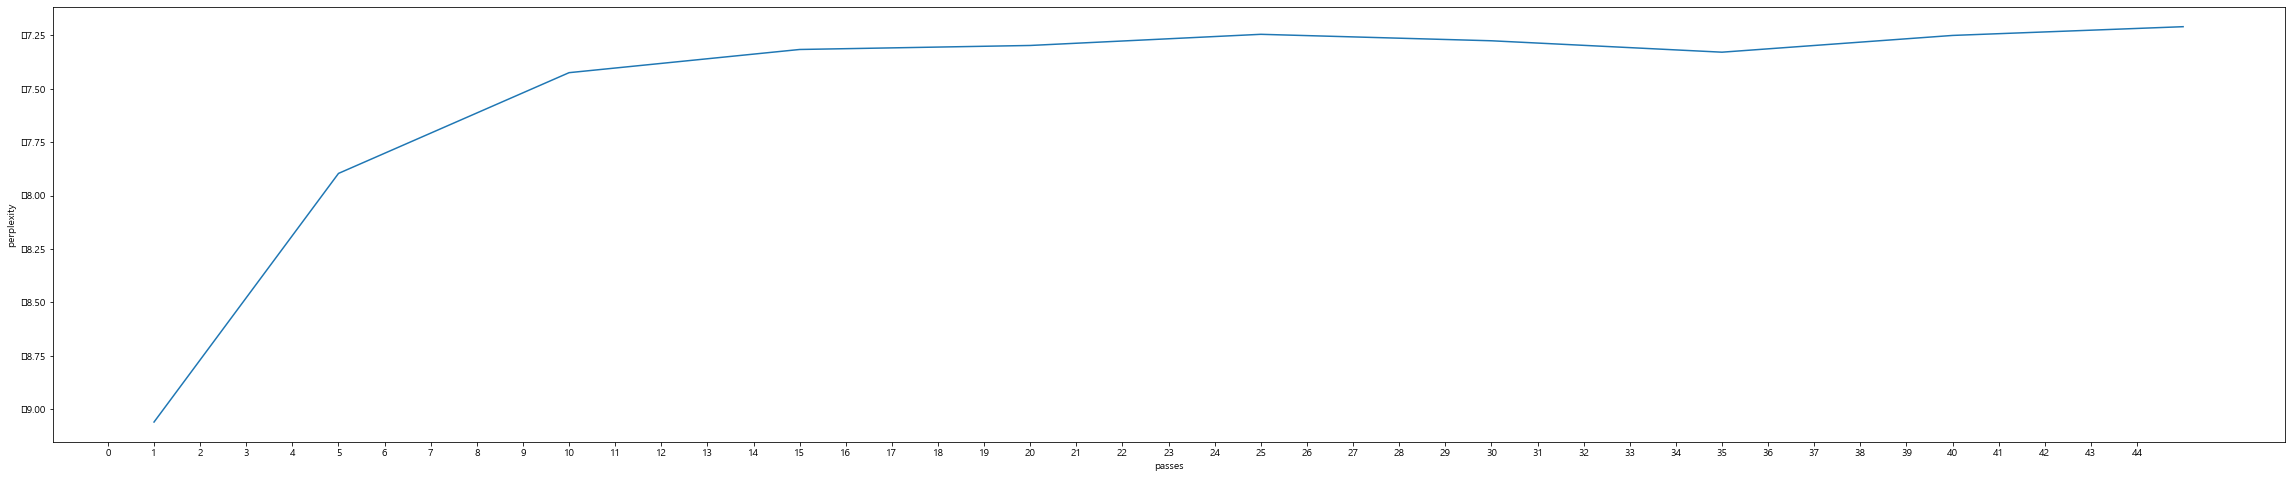

In [79]:
plt.figure(figsize=(40,8))
plt.plot(passes, tokens_perplexities)

plt.xlabel("passes")
plt.ylabel("perplexity")

plt.xticks(np.arange(0, 45))

plt.show()

In [80]:
# coherence와 perplexity 계산을 통해 최적의 토픽 개수 구하기
perplexities_values=[]
coherences_values=[]

for i in range(1, 21):

    lda_model = LdaMulticore(corpus=tokens_corpus, id2word = tokens_dictionary, num_topics = i, passes = 5)
#    print('number of topics',p,time.time() - tic)
    coherence_model = CoherenceModel(model = lda_model, corpus = tokens_corpus, coherence = 'u_mass')
    tok_coherence = coherence_model.get_coherence()
    print("coherence:", tok_coherence)
    coherences_values.append(tok_coherence)
    print("perplexity:", lda_model.log_perplexity(tokens_corpus), "\n")
    perplexities_values.append(lda_model.log_perplexity(tokens_corpus))

coherence: -0.37983570863045607
perplexity: -6.923023001361476 

coherence: -0.5270262027081986
perplexity: -6.855139317609758 

coherence: -0.8787179146946036
perplexity: -6.806839310059488 

coherence: -0.8306845116477619
perplexity: -6.825481836983445 

coherence: -2.3039994283804166
perplexity: -6.788968786947988 

coherence: -1.3936057016216241
perplexity: -6.761636240441384 

coherence: -0.9579589960502678
perplexity: -6.757894093914649 

coherence: -0.8460068046400382
perplexity: -6.7963663414126385 

coherence: -0.8667933186329169
perplexity: -6.763883369343509 

coherence: -0.9645238703107223
perplexity: -6.791982813448315 

coherence: -0.7505727592977607
perplexity: -6.758858242272454 

coherence: -0.9706620808382148
perplexity: -6.8481409714890615 

coherence: -0.9123548126766288
perplexity: -6.812430200954801 

coherence: -0.8683692913618726
perplexity: -6.822492927607607 

coherence: -0.9264180068185516
perplexity: -6.841999970193126 

coherence: -0.9066550552922886
perple

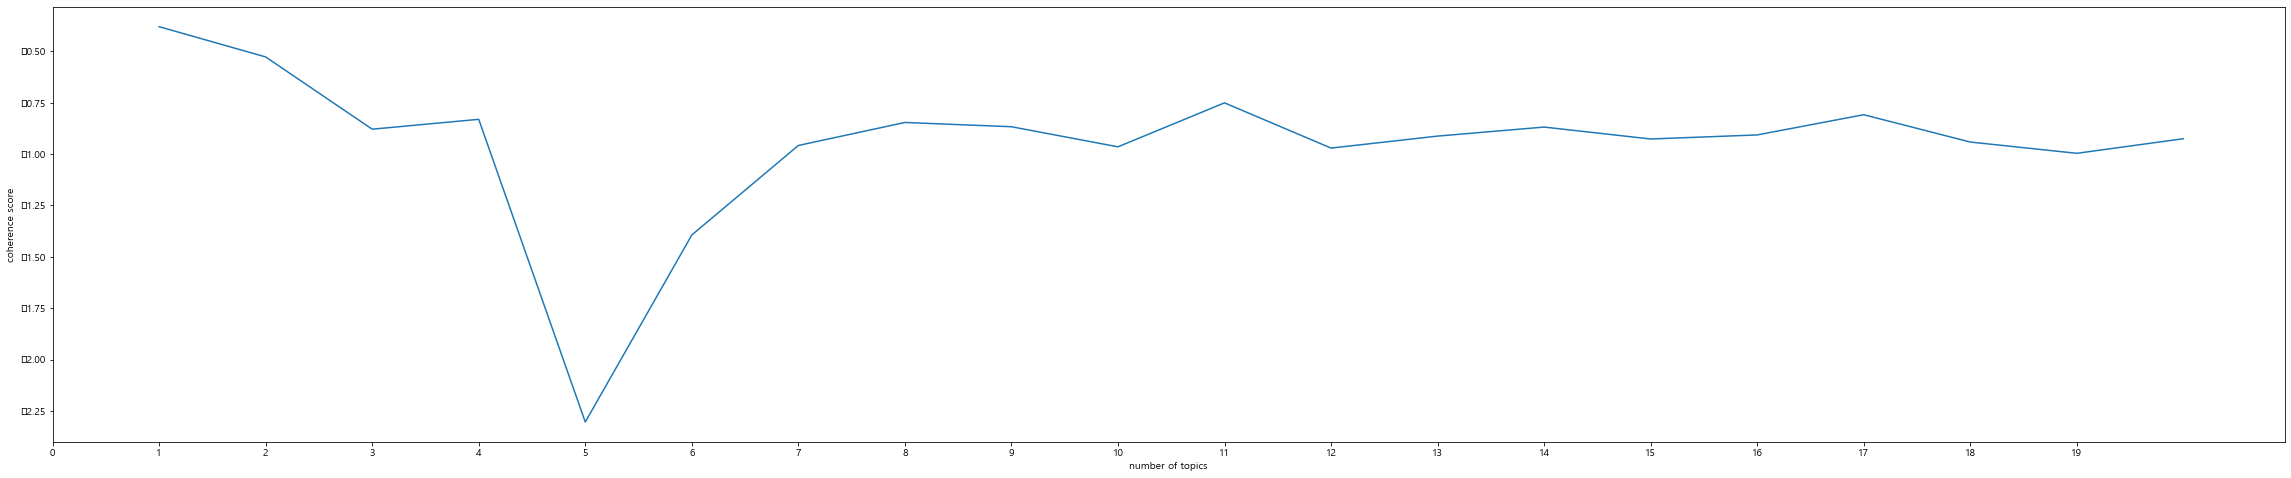

In [81]:
x = np.arange(1,21)
plt.figure(figsize=(40,8))
plt.plot(x, coherences_values)
plt.xlabel("number of topics")
plt.ylabel("coherence score")

plt.xticks(np.arange(0, 20))

plt.show()

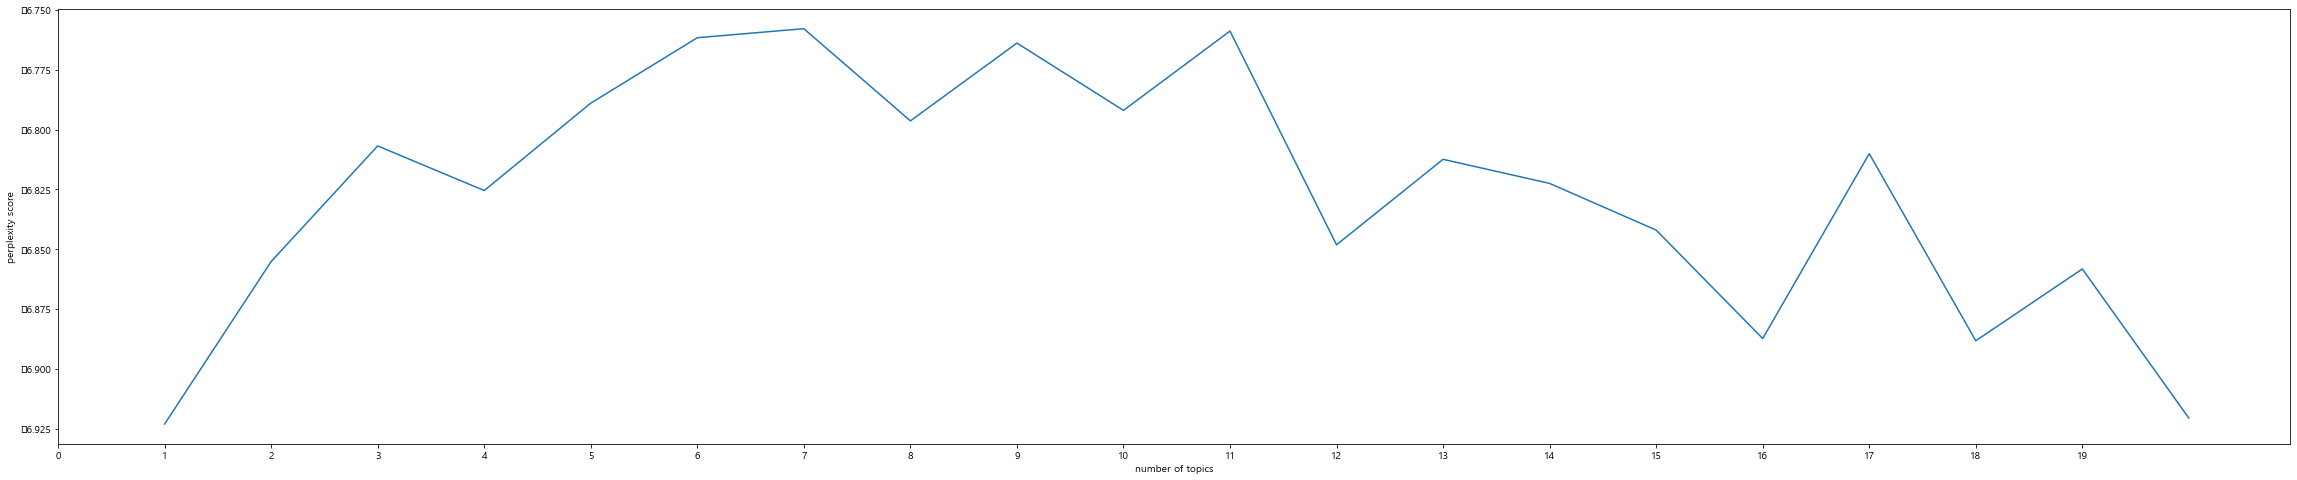

In [82]:
x = np.arange(1,21)
plt.figure(figsize=(40,8))

plt.plot(x, perplexities_values)
plt.xlabel("number of topics")
plt.ylabel("perplexity score")

plt.xticks(np.arange(0, 20))

plt.show()

In [83]:
# LDA Modeling - 정해진 topic 개수와 pass 사용
lda_model = LdaMulticore(corpus = tokens_corpus, num_topics = 4, id2word = tokens_dictionary, passes = 5, iterations=400)
topics = lda_model.print_topics()
for topic in topics:
    print(topic)

(0, '0.030*"게임" + 0.012*"카지노" + 0.011*"시장" + 0.011*"등" + 0.010*"수" + 0.010*"소셜" + 0.010*"것" + 0.008*"코로나" + 0.007*"온라인" + 0.007*"매출"')
(1, '0.031*"게임" + 0.011*"것" + 0.010*"네오위즈" + 0.010*"등" + 0.007*"매출" + 0.007*"출시" + 0.007*"개발" + 0.007*"수" + 0.006*"사업" + 0.006*"이"')
(2, '0.034*"게임" + 0.028*"매출" + 0.019*"전" + 0.017*"대비" + 0.013*"증가" + 0.012*"년" + 0.011*"동기" + 0.011*"부문" + 0.010*"등" + 0.009*"기록"')
(3, '0.052*"게임" + 0.024*"스포츠" + 0.019*"예측" + 0.017*"이용자" + 0.015*"웹" + 0.013*"승부" + 0.011*"등" + 0.010*"인증" + 0.010*"수" + 0.008*"보호"')


In [86]:
# 헤더 만들어 테이블 형식으로 정리
topic_words = {};

for i in range(4): 
    words = lda_model.show_topic(i, topn = 13)
    topic_words['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
    
topic_table = pd.DataFrame(topic_words)
topic_table

,Topic # 01,Topic # 02,Topic # 03,Topic # 04
0,게임,게임,게임,게임
1,카지노,것,매출,스포츠
2,시장,네오위즈,전,예측
3,등,등,대비,이용자
4,수,매출,증가,웹
5,소셜,출시,년,승부
6,것,개발,동기,등
7,코로나,수,부문,인증
8,온라인,사업,등,수
9,매출,이,기록,보호


In [89]:
# LDA visualization

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, tokens_corpus, tokens_dictionary)
pyLDAvis.display(vis)